# Gün 2 bölüm 2: Bulaşma dinamiklerini tanıtmak

<div style="background: #f8f9fa; padding: 0.5rem 1rem; border-radius: 8px; margin-bottom: 1rem; border-left: 4px solid #007bff;">
<a href="../../index.ipynb" style="text-decoration: none; color: #007bff; font-weight: bold;">← Kurs Dizinine Geri Dön</a> | 
<a href="../../index-tr.ipynb" style="text-decoration: none; color: #dc3545; font-weight: bold;">🇹🇷 Türkçe Index</a>
</div>

---

Bir SIR modeli kurduk, ana model parametrelerindeki değişimin salgın büyüklüğünü nasıl etkileyebileceğini araştırdık ve tamamen dinamik bir SIR modelinden model çıktılarını değerlendirdik. Teoride R0, Reff, sürü bağışıklığı eşiği ve popülasyon yenilenmesi kavramlarını araştırdık. Bu pratikte bu kavramları daha fazla keşfetmek için önceki pratiğimizi temel alacağız.

## 1. COVID-19 için bir model

SARS-Cov2 son 2 yıldır dünyanın hemen hemen her ülkesinde insandan insana aktif olarak bulaştı. 2019'un sonundan bu yana virüsün temel dinamikleri hakkında önemli içgörüler edindik ve bulaşmasını tanımlamak için önemli parametreleri ölçebildik. Burada önceki SIR modelimizi SARS-Cov2'nin önemli özelliklerini yansıtacak şekilde uyarlayacağız ve modelimizi bilgilendirmek için yayınlanmış literatüre dayanacağız.

SARS-Cov2'nin insandan insana bulaştığını biliyoruz, ayrıca bulaşmanın ardından çoğu bireyin hastalığın semptomatik bir formunu geliştirmesiyle sona eren bir kuluçka dönemi izlediğini biliyoruz. Bireyler kuluçka döneminde bulaştırıcı değildirler. Liu ve diğerleri, 2020'de yaptıkları sistematik derlemede medyanı 2.79 (1.5 ile 6.68 arasında değişen) olan bir R0 değeri tahmin etmişlerdir(1). Benzer şekilde, McAloon ve diğerleri kuluçka döneminin süresini gözden geçirmiş ve 5.8 günlük bir ortalama değer bulmuşlardır (%95 GA 5-6.7)(2). Bulaştırıcılık dönemi, hastalık şiddetindeki geniş varyasyonlar nedeniyle en heterojen bilgi parçalarından biridir. Ancak basitlik için, başka yerde rapor edildiği gibi ortalama bulaştırıcılık döneminin (semptom başlangıcından negatif PCR'ye kadar) ~13 gün olduğunu söyleyebiliriz (3). Son olarak, covid-19 için vaka ölüm oranının önemli yaş kalıpları ve ayrıca ülkeler arası varyasyonları takip ettiği anlaşılmaktadır. Ancak basitlik için %4'lük bir tahmin alacağız (4).

### Vaka çalışması

Gelecek yıl boyunca salgının muhtemel seyrini (hiçbir müdahale uygulanmazsa) projelendirmek için basit bir model yazmanız için görevlendirildiniz. İlgilenilen popülasyon 100.000 kişilik bir kasabadır. Şu anda popülasyon genelinde yapılan tarama 500 bulaştırıcı vaka buldu.

1)  Yukarıdaki metni takip ederek, ilgili hastalık evrelerini içeren bir model tasarlayabilir misiniz ve geçiş oranlarını buna göre tanımlayabilir misiniz? (kalem ve kağıt kullanın).

2)  Covid-19 için bir model tasarladığınıza göre, bu model için diferansiyel denklemleri yazabilir misiniz?

3)  Aşağıdaki kodu (önceki pratiğimizden) kullanarak, yeni model özelliklerini tanıtmak için kodunuzu değiştirmeyi deneyin.\

4)  Modelinizi çalıştırdıktan sonra, aşağıdaki bilgileri verebilir misiniz:

<!-- -->

a)  Şu andan bir yıl sonra salgının beklenen büyüklüğü nedir?

    **Cevap:** ~88.220 kişi

b)  Mevcut koşullar altında kaç ölümün meydana geleceği öngörülmektedir?

    **Cevap:** ~3.675

c)  Salgın ne zaman zirve yapacak?

    **Cevap: ~83 gün**

d)  Bu salgın hakkındaki mevcut bilgiler göz önüne alındığında, sürü bağışıklığı eşiği için değer nedir?

    **Cevap:**

    **HIT = 1 - 1/R0**

    **HIT = 1- 1/2.79 = 0.64; Bu da popülasyonun %64'üne bağışıklık getirmenin salgının azalmasına neden olduğu anlamına gelir.**

Not: Soru işaretlerini (?) arayın ve gerektiği gibi değiştirin.

here() starts at C:/Users/juano/Dropbox/Code/Git/ankara-modelling-2025-notebooks

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


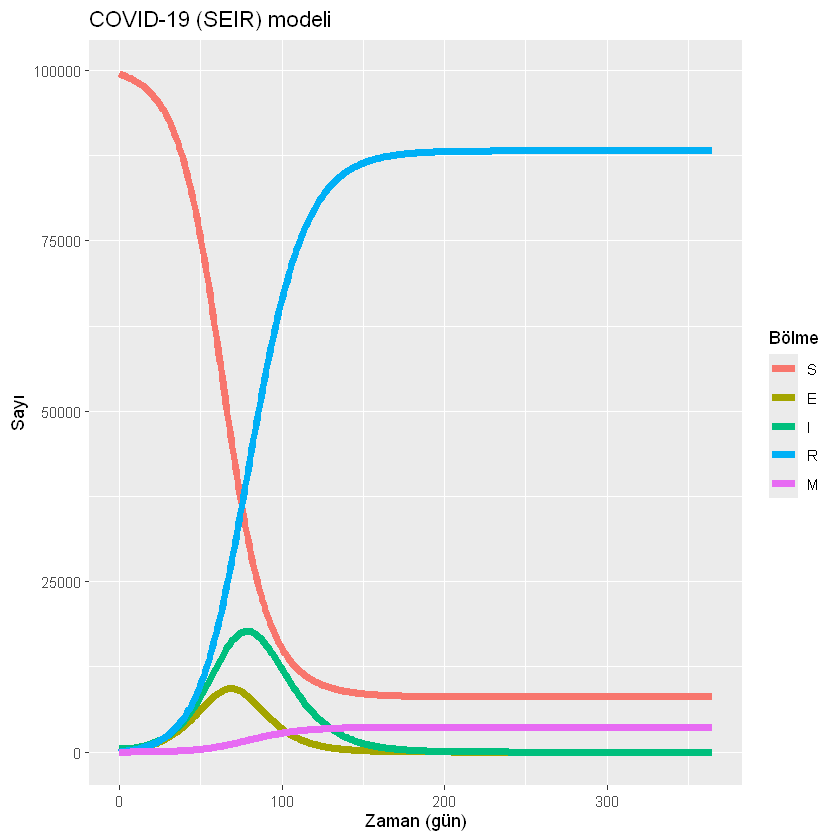

In [1]:
# PAKETLERİ YÜKLE:
library(deSolve)
library(reshape2)
library(ggplot2)
library(here)

setwd(here())
# Popülasyon büyüklüğü:
N <- 100000

# MODEL GİRDİLERİ:

# Başlangıç koşulları
initial_state_values <- c(
  S = N-500,    # <------------S için başlangıç koşullarını yaz
  E = 0,
  I = 500,    # <----------- I için başlangıç koşullarını yaz
  R = 0,
  M = 0)           

# Günlük parametre değerleri  <--------------Aşağıdaki model parametrelerini tamamla

epsilon <- 1/5.8    # semptom başlangıç oranı  
gamma   <- 1/13     # İyileşme oranı 
R0      <- 2.79      # R0
beta    <- R0/13       # enfeksiyon oranı
CFR     <- 0.04       # Vaka ölüm oranı
mu      <- gamma*CFR/(1-CFR)       # Ölüm oranı [rekabet eden tehlikeleri hatırla! gamma*CFR/(1-CFR) ]


parameters <- c(beta,epsilon, gamma, mu)


# MODEL FONKSİYONU: 
times <- seq(from = 0, to = 365, by = 1)   # 0'dan 365 güne kadar günlük aralıklarla

seir_model <- function(time, state, parameters) {  
  
  with(as.list(c(state, parameters)), {     
    
    # Toplam popülasyon büyüklüğü N'i hesaplama (her bölmedeki kişi sayısının toplamı)
    
    N <- S+E+I+R  # <----------------- toplam popülasyonu tanımla
    
    # FOI'yi hesaplama
    
    lambda <- beta*I/N  #  Enfeksiyon kuvvetini nasıl tanımlayabiliriz? 
    
    # Diferansiyel denklemler
    dS <-  -lambda*S 
    dE <-   lambda*S - E*epsilon      # E için diferansiyel denklemi yazabilir misin? 
    dI <-   E*epsilon - I*(gamma+mu)     
    dR <-   gamma * I 
    dM <-   I*mu
    
    return(list(c(dS, dE, dI, dR, dM))) 
  })
  
}


# MODEL ÇIKTISI (diferansiyel denklemleri çözme):

# ode entegrasyon algoritmasını kullanarak diferansiyel denklemleri çözme
output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = seir_model,
                            parms = parameters))



# çıktı veri setini uzun formata çevir
output_long <- melt(as.data.frame(output), id = "time")                 


# S, I ve R bölmelerindeki kişi sayısını zaman içinde çiz
ggplot(data = output_long,                                               # çizilecek verileri içeren nesneyi belirt
       aes(x = time, y = value, colour = variable, group = variable)) +  # sütunları eksenlere ve gruplara ata
  geom_line(size=2) +                                                          # verileri çizgi olarak temsil et
  xlab("Zaman (gün)")+                                                   # x ekseni için etiket ekle
  ylab("Sayı") +                                                       # y ekseni için etiket ekle
  labs(colour = "Bölme",                                           # açıklama başlığı ekle  
       title = "COVID-19 (SEIR) modeli")    
   

## 2. Etkin üreme sayısı

Salgın yanıtının planlanması için çok faydalı içgörüler sağladınız. Sağlık otoriteleri önümüzdeki 40 gün içinde aşılamayı başlatmayı planlıyor.

1)  40 gün içinde beklenen etkin üreme sayısı nedir?

**Cevap: ~ 2.4**

Modelin her aşamasında popülasyonun oranını zaman içinde tahmin etmek için aşağıdaki kodu kullanın.

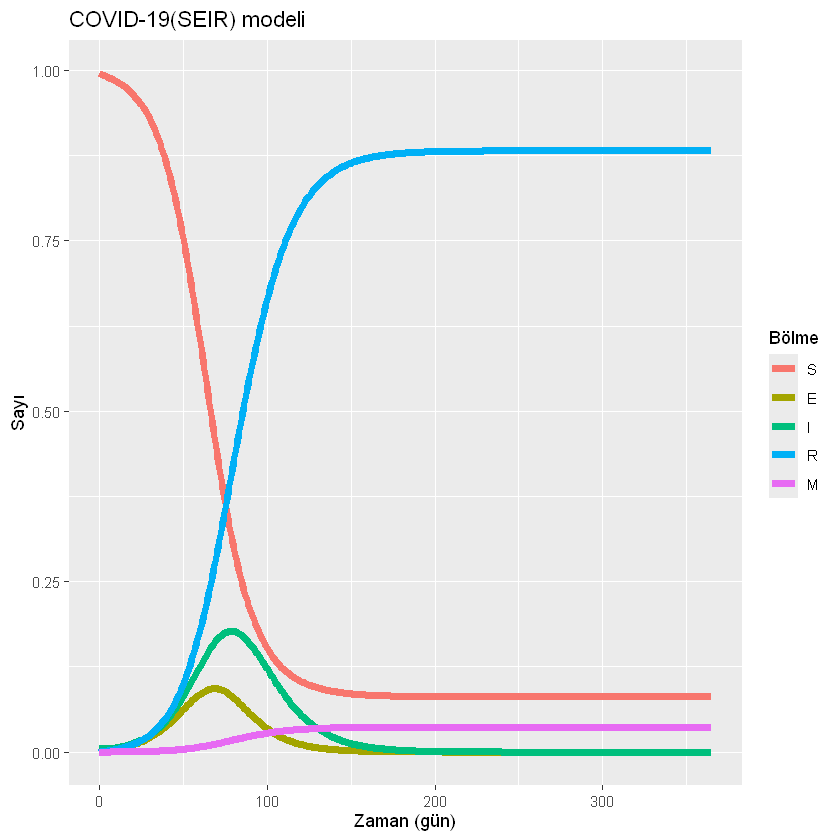

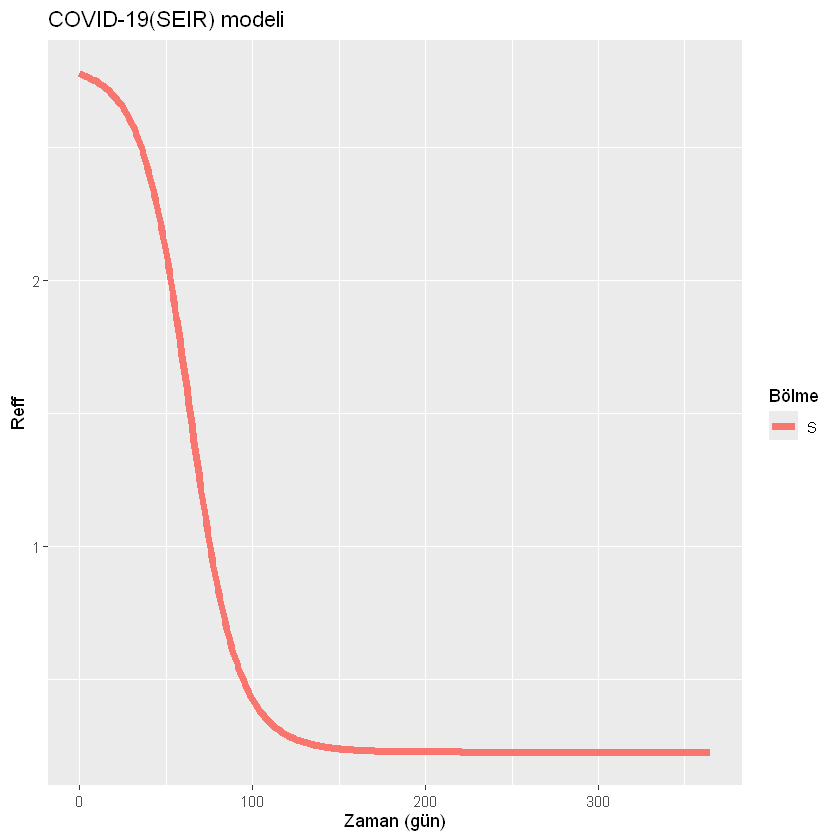

In [2]:
# Bireylerin oranını çiz 

output2_long<- output_long
output2_long$value<-output_long$value/N

# S, I ve R bölmelerindeki kişilerin oranını zaman içinde çiz
ggplot(data = output2_long,                                               # çizilecek verileri içeren nesneyi belirt
       aes(x = time, y = value, colour = variable, group = variable)) +  # sütunları eksenlere ve gruplara ata
  geom_line(size=2) +                                                    # verileri çizgi olarak temsil et
  xlab("Zaman (gün)")+                                                   # x ekseni için etiket ekle
  ylab("Sayı") +                                                       # y ekseni için etiket ekle
  labs(colour = "Bölme",                                           # açıklama başlığı ekle  
       title = "COVID-19(SEIR) modeli")



## Reff'i hesapla

Reff<-output2_long[output2_long$variable=="S",] # bu zaman içinde duyarlı oranıdır

Reff$value<- Reff$value * R0 #<------------- Reff için hesaplamayı tamamla
  
  # S, I ve R bölmelerindeki kişilerin oranını zaman içinde çiz
  ggplot(data = Reff,                                               # çizilecek verileri içeren nesneyi belirt
         aes(x = time, y = value, colour = variable, group = variable)) +  # sütunları eksenlere ve gruplara ata
  geom_line(size=2) +                                                          # verileri çizgi olarak temsil et
  xlab("Zaman (gün)")+                                                   # x ekseni için etiket ekle
  ylab("Reff") +                                                       # y ekseni için etiket ekle
  labs(colour = "Bölme",                                           # açıklama başlığı ekle  
       title = "COVID-19(SEIR) modeli")

2)  Modelinizin diğer bağlamlarda görüldüğü gibi sonraki dalgaları neden yeniden üretmediğini açıklamanız isteniyor. Modelinizdeki hangi varsayımların ve basitleştirmelerin bu davranışı engellediğini düşünebilir misiniz?

    **Cevap:** **Kapalı bir insan kohortunu modelliyoruz, bu da duyarlı insan havuzunda yenilenme olmadığı anlamına geliyor. Ayrıca herhangi bir mevsimselliğe (yıl boyunca temas kalıplarındaki değişiklikler veya bulaşmada varyasyonlara neden olabilecek diğer dış faktörler) izin vermiyoruz**

3)  Aşılamayı simüle etmek için potansiyel model tasarımları düşünebilir misiniz?

    **Cevap: S'den yeni bir V bölmesine ek bir akış ekle. Bu geçiş kapsamı yansıtmalıdır. Ve önemlisi, aşı etkinliği "V"ye geçmeyen bir kesir olarak belirtilmeli veya "V"den enfeksiyon kuvvetinde bir azalma anlamına gelebilir**

## Kaynaklar

1.  Liu Y, Gayle AA, Wilder Smith A, Rocklov J. Reproductive number of Covid19 is higher compared to SARS coronavirus. J Travel Med. 2020;27(2):taaa021. doi: 10.1093/jtm/taaa021.
2.  McAloon C, Collins Á, Hunt K, et alIncubation period of COVID-19: a rapid systematic review and meta-analysis of observational researchBMJ Open 2020;10:e039652. doi: 10.1136/bmjopen-2020-039652
3.  Byrne AW, McEvoy D, Collins AB, et alInferred duration of infectious period of SARS-CoV-2: rapid scoping review and analysis of available evidence for asymptomatic and symptomatic COVID-19 casesBMJ Open 2020;10:e039856. doi: 10.1136/bmjopen-2020-039856
4.  Verity, R. et al. Estimates of the severity of coronavirus disease 2019: a model-based analysis. Lancet Infect. Dis. 20, 669--677 (2020).